In [1]:
!pip install torch sentence-transformers scikit-learn numpy pandas matplotlib


In [2]:
# CELL 2: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer
import json
import os
from typing import List, Dict, Tuple, Optional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load embedding model
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
print("✓ Embedding model loaded")

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data/training', exist_ok=True)
print("✓ Directory structure ready")


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Embedding model loaded
✓ Directory structure ready


No log file found at data/logs/feedback.jsonl

No training data found. Creating synthetic data for testing...
✓ Created 10 synthetic samples

--- Training Data Sample ---
     user_id                                           text  rating  \
0  synthetic       The mountain stands tall against the sky    0.90   
1  synthetic                Trees sway gently in the breeze    0.85   
2  synthetic                      Rocks and dirt everywhere    0.30   
3  synthetic                  The forest is green and stuff    0.40   
4  synthetic  Majestic eagles soar through mountain valleys    0.95   

  event_type                   timestamp  
0       rate  2025-11-03T20:52:47.897984  
1       rate  2025-11-03T20:52:47.897996  
2       rate  2025-11-03T20:52:47.898008  
3       rate  2025-11-03T20:52:47.898010  
4       rate  2025-11-03T20:52:47.898013  

Rating distribution:
count    10.000000
mean      0.680000
std       0.287093
min       0.300000
25%       0.400000
50%       0.865000
75%     

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Prepared 10 samples
  Embedding dimension: 768
  Rating range: [0.30, 0.95]

Train set: 8 samples
Val set:   2 samples
✓ Created dataloaders (batch_size=16)
✓ Reward model created

Model architecture:
RewardModel(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Total parameters: 238,081
Trainable parameters: 238,081

TRAINING REWARD MODEL
Epoch   1/50
  Train Loss: 0.1034
  Val Loss:   0.0582
  Val MSE:    0.0582
  Val MAE:    0.2248
Epoch  10/50
  Train Loss: 0.0896
  Val Loss:   0.0525
  Val MSE:    0.0525
  Val MAE:    0.2218
  ✓ Saved best model (val_loss: 0.0525)
Epoch  20

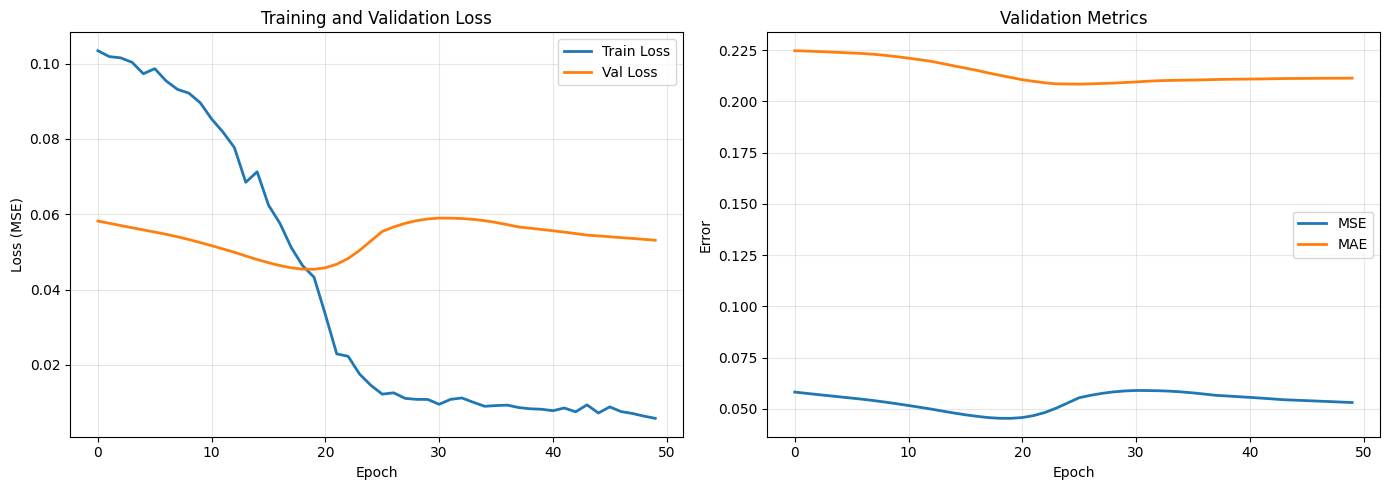

✓ Saved training history plot
✓ Loaded best model from epoch 20

=== EVALUATION METRICS ===
MSE:  0.0454
MAE:  0.2117
RMSE: 0.2131
Correlation: 1.0000


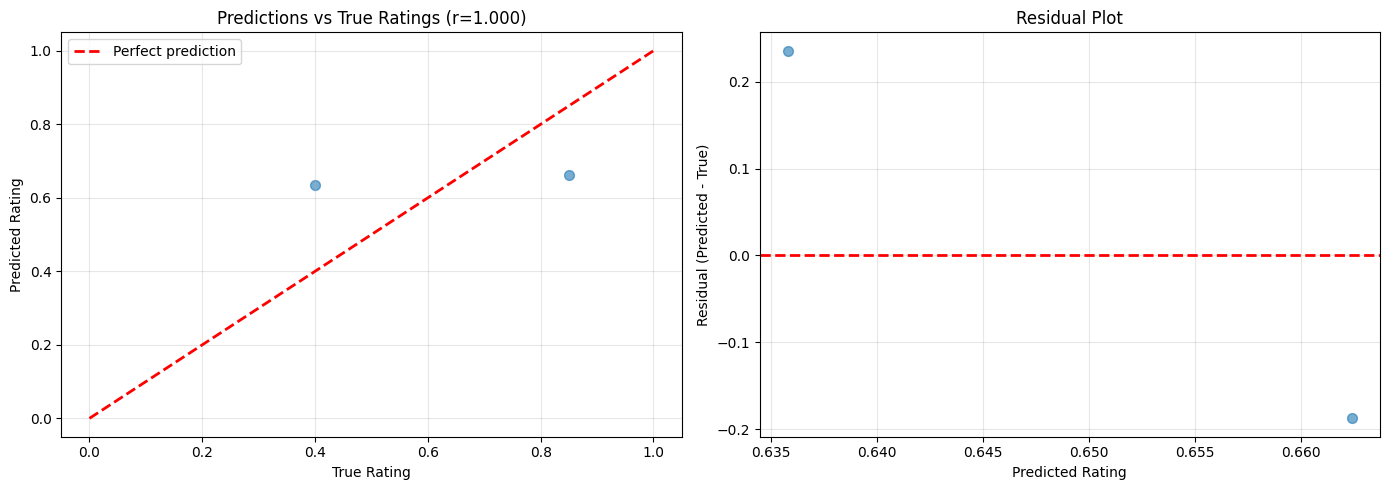

✓ Saved prediction analysis plot

TESTING ON SAMPLE TEXTS

--- Sample Predictions ---

Text: The majestic mountain rises above the clouds in splendor
Predicted Rating: 0.747

Text: Mountains and stuff
Predicted Rating: 0.644

Text: Your love shines like the morning sun
Predicted Rating: 0.739

Text: I like you
Predicted Rating: 0.562

Text: The gentle breeze whispers through ancient oak trees
Predicted Rating: 0.667
✓ Saved model to models/reward_model_final.pt
✓ Loaded model from models/reward_model_final.pt
  Training info: {'best_val_loss': 0.045401282608509064, 'num_epochs': 50, 'train_samples': 8, 'val_samples': 2}
✓ Exported training report to data/training/report.json

✓ Notebook 4 Complete - Reward model training ready!
Next: Run notebook 05 for evaluation metrics and testing


In [4]:
# ============================================================================
# CELL 3: Load and Prepare Training Data
# ============================================================================
def load_feedback_logs(log_file: str = 'data/logs/feedback.jsonl') -> pd.DataFrame:
    """Load feedback logs and extract training data."""

    if not os.path.exists(log_file):
        print(f"No log file found at {log_file}")
        return pd.DataFrame()

    logs = []
    with open(log_file, 'r') as f:
        for line in f:
            logs.append(json.loads(line.strip()))

    # Extract feedback with ratings
    training_data = []
    for log in logs:
        if log['event_type'] in ['select', 'rate', 'reject']:
            data = log['data']

            # Extract rating
            if 'rating' in data:
                rating = data['rating']
            elif log['event_type'] == 'select':
                rating = data.get('score', 0.8)  # Default high for selections
            elif log['event_type'] == 'reject':
                rating = 0.2  # Low for rejections
            else:
                continue

            # Extract text
            text = data.get('text', '')
            if not text:
                continue

            training_data.append({
                'user_id': log['user_id'],
                'text': text,
                'rating': rating,
                'event_type': log['event_type'],
                'timestamp': log['timestamp']
            })

    df = pd.DataFrame(training_data)
    print(f"✓ Loaded {len(df)} training samples from logs")

    return df

# Load training data
train_df = load_feedback_logs()

if train_df.empty:
    print("\nNo training data found. Creating synthetic data for testing...")

    # Create synthetic training data
    synthetic_samples = []
    themes = ['nature', 'love', 'melancholy', 'joy']

    sample_texts = {
        'nature': [
            ("The mountain stands tall against the sky", 0.9),
            ("Trees sway gently in the breeze", 0.85),
            ("Rocks and dirt everywhere", 0.3),
            ("The forest is green and stuff", 0.4),
            ("Majestic eagles soar through mountain valleys", 0.95)
        ],
        'love': [
            ("Your eyes sparkle like stars above", 0.9),
            ("Two hearts beating as one", 0.88),
            ("I like you I guess", 0.3),
            ("Love is nice", 0.4),
            ("In your embrace I find my home", 0.92)
        ]
    }

    for theme, texts in sample_texts.items():
        for text, rating in texts:
            synthetic_samples.append({
                'user_id': 'synthetic',
                'text': text,
                'rating': rating,
                'event_type': 'rate',
                'timestamp': datetime.now().isoformat()
            })

    train_df = pd.DataFrame(synthetic_samples)
    print(f"✓ Created {len(train_df)} synthetic samples")

print("\n--- Training Data Sample ---")
print(train_df.head())
print(f"\nRating distribution:")
print(train_df['rating'].describe())

# ============================================================================
# CELL 4: Prepare Embeddings
# ============================================================================
def prepare_embeddings_and_labels(
    df: pd.DataFrame,
    embedding_model
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare embeddings and labels for training.

    Returns:
        X: embeddings array (n_samples, embedding_dim)
        y: ratings array (n_samples,)
    """
    texts = df['text'].tolist()
    ratings = df['rating'].values

    print("Computing embeddings...")
    embeddings = embedding_model.encode(
        texts,
        show_progress_bar=True,
        batch_size=32
    )

    return embeddings, ratings

# Prepare data
X, y = prepare_embeddings_and_labels(train_df, embedding_model)
print(f"\n✓ Prepared {X.shape[0]} samples")
print(f"  Embedding dimension: {X.shape[1]}")
print(f"  Rating range: [{y.min():.2f}, {y.max():.2f}]")

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Val set:   {X_val.shape[0]} samples")

# ============================================================================
# CELL 5: Create PyTorch Dataset
# ============================================================================
class RewardDataset(Dataset):
    """Dataset for reward model training."""

    def __init__(self, embeddings: np.ndarray, ratings: np.ndarray):
        self.embeddings = torch.FloatTensor(embeddings)
        self.ratings = torch.FloatTensor(ratings)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.ratings[idx]

# Create datasets
train_dataset = RewardDataset(X_train, y_train)
val_dataset = RewardDataset(X_val, y_val)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Created dataloaders (batch_size={batch_size})")

# ============================================================================
# CELL 6: Define Reward Model Architecture
# ============================================================================
class RewardModel(nn.Module):
    """
    Simple MLP reward model.

    Takes text embeddings and predicts user rating (0-1).
    """

    def __init__(
        self,
        input_dim: int = 768,
        hidden_dims: List[int] = [256, 128, 64],
        dropout: float = 0.2
    ):
        super(RewardModel, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Output layer (single value between 0 and 1)
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)

    def predict(self, embeddings: np.ndarray) -> np.ndarray:
        """Predict rewards for embeddings."""
        self.eval()
        with torch.no_grad():
            x = torch.FloatTensor(embeddings).to(next(self.parameters()).device)
            preds = self.forward(x)
            return preds.cpu().numpy()

# Create model
input_dim = X_train.shape[1]
model = RewardModel(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.2
)
model.to(device)

print("✓ Reward model created")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ============================================================================
# CELL 7: Training Functions
# ============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for embeddings, ratings in dataloader:
        embeddings = embeddings.to(device)
        ratings = ratings.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(embeddings)
        loss = criterion(predictions, ratings)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for embeddings, ratings in dataloader:
            embeddings = embeddings.to(device)
            ratings = ratings.to(device)

            predictions = model(embeddings)
            loss = criterion(predictions, ratings)

            total_loss += loss.item()
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(ratings.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)

    return avg_loss, mse, mae, np.array(all_preds), np.array(all_targets)

# ============================================================================
# CELL 8: Train the Model
# ============================================================================
# Training configuration
num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-5

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_mse': [],
    'val_mae': []
}

print("\n" + "=" * 60)
print("TRAINING REWARD MODEL")
print("=" * 60)

best_val_loss = float('inf')
best_model_path = 'models/reward_model_best.pt'

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_mse, val_mae, val_preds, val_targets = validate(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mse'].append(val_mse)
    history['val_mae'].append(val_mae)

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val MSE:    {val_mse:.4f}")
        print(f"  Val MAE:    {val_mae:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'input_dim': input_dim
        }, best_model_path)
        if (epoch + 1) % 10 == 0:
            print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")

print(f"\n✓ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

# ============================================================================
# CELL 9: Plot Training History
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics plot
axes[1].plot(history['val_mse'], label='MSE', linewidth=2)
axes[1].plot(history['val_mae'], label='MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Error')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/training/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved training history plot")

# ============================================================================
# CELL 10: Evaluate Model on Validation Set
# ============================================================================
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Get predictions
model.eval()
val_preds = model.predict(X_val)

# Evaluation metrics
mse = mean_squared_error(y_val, val_preds)
mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mse)

print("\n=== EVALUATION METRICS ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Correlation
correlation = np.corrcoef(y_val, val_preds)[0, 1]
print(f"Correlation: {correlation:.4f}")

# ============================================================================
# CELL 11: Visualize Predictions
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_val, val_preds, alpha=0.6, s=50)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Predictions vs True Ratings (r={correlation:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.05, 1.05)
axes[0].set_ylim(-0.05, 1.05)

# Residual plot
residuals = val_preds - y_val
axes[1].scatter(val_preds, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Rating')
axes[1].set_ylabel('Residual (Predicted - True)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/training/prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved prediction analysis plot")

# ============================================================================
# CELL 12: Test on Sample Texts
# ============================================================================
print("\n" + "=" * 60)
print("TESTING ON SAMPLE TEXTS")
print("=" * 60)

test_samples = [
    "The majestic mountain rises above the clouds in splendor",
    "Mountains and stuff",
    "Your love shines like the morning sun",
    "I like you",
    "The gentle breeze whispers through ancient oak trees"
]

print("\n--- Sample Predictions ---")
for text in test_samples:
    # Compute embedding
    emb = embedding_model.encode([text])

    # Predict rating
    pred_rating = model.predict(emb)[0]

    print(f"\nText: {text}")
    print(f"Predicted Rating: {pred_rating:.3f}")

# ============================================================================
# CELL 13: Save Model with Metadata
# ============================================================================
def save_model_with_metadata(
    model,
    metadata: Dict,
    filepath: str = 'models/reward_model_final.pt'
):
    """Save model with training metadata."""

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': metadata['input_dim'],
            'hidden_dims': [256, 128, 64],
            'dropout': 0.2
        },
        'training_info': {
            'best_val_loss': metadata.get('best_val_loss'),
            'num_epochs': metadata.get('num_epochs'),
            'train_samples': metadata.get('train_samples'),
            'val_samples': metadata.get('val_samples')
        },
        'embedding_model': 'sentence-transformers/all-mpnet-base-v2'
    }, filepath)

    print(f"✓ Saved model to {filepath}")

# Save final model
save_model_with_metadata(
    model,
    metadata={
        'input_dim': input_dim,
        'best_val_loss': best_val_loss,
        'num_epochs': num_epochs,
        'train_samples': len(X_train),
        'val_samples': len(X_val)
    }
)

# ============================================================================
# CELL 14: Load and Use Model Function
# ============================================================================
def load_reward_model(filepath: str = 'models/reward_model_final.pt'):
    """Load a saved reward model."""

    checkpoint = torch.load(filepath, map_location=device)

    # Recreate model
    config = checkpoint['model_config']
    model = RewardModel(
        input_dim=config['input_dim'],
        hidden_dims=config['hidden_dims'],
        dropout=config['dropout']
    )

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"✓ Loaded model from {filepath}")
    print(f"  Training info: {checkpoint.get('training_info', {})}")

    return model, checkpoint

# Test loading
loaded_model, checkpoint_info = load_reward_model()

# ============================================================================
# CELL 15: Export Training Report
# ============================================================================
def export_training_report(history, metadata, filepath='data/training/report.json'):
    """Export training report with metrics."""

    report = {
        'metadata': metadata,
        'final_metrics': {
            'best_val_loss': float(min(history['val_loss'])),
            'final_val_mse': float(history['val_mse'][-1]),
            'final_val_mae': float(history['val_mae'][-1]),
            'best_epoch': int(np.argmin(history['val_loss']))
        },
        'history': {
            'train_loss': [float(x) for x in history['train_loss']],
            'val_loss': [float(x) for x in history['val_loss']],
            'val_mse': [float(x) for x in history['val_mse']],
            'val_mae': [float(x) for x in history['val_mae']]
        }
    }

    with open(filepath, 'w') as f:
        json.dump(report, f, indent=2)

    print(f"✓ Exported training report to {filepath}")

export_training_report(
    history,
    metadata={
        'model_type': 'MLP Reward Model',
        'input_dim': input_dim,
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'train_samples': len(X_train),
        'val_samples': len(X_val)
    }
)

print("\n✓ Notebook 4 Complete - Reward model training ready!")
print("Next: Run notebook 05 for evaluation metrics and testing")